In [1]:
#!/usr/bin/env python3

from parse_shark import get_range_and_ul_count
from parse_tottag import get_rssi, get_raw
from parse_rtt import get_rssi_rtt, get_raw_rtt, merge_tottag
from parse_bot import get_log, get_yaws
import os
from bisect import bisect_left
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

from mobile_experiment import dist

import nest_asyncio
nest_asyncio.apply()

def cdf(x, plot=True, *args, **kwargs):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return plt.plot(x, y, *args, **kwargs) if plot else (x, y)

def align(opo,tottag,bot1,fixed_point, magic):
    opo_log = get_range_and_ul_count(opo) #[t,name,range_dt,ul_count, dist] note: rx only
    tottag_rssi = get_rssi(tottag) #[timestamp, rssi, channel]
    tottag_raw = get_raw(tottag) # [timestamp, device_id, median, raw]
    bot1_log = get_log(bot1) #[timestamp,[x,y],[q_x,q_y,q_z,q_w]]

    bot1_yaws = get_yaws(bot1_log)

    ## align opo and bots
    bot1_stamps=[x[0] for x in bot1_log]
    opo_stamps=[x[0] for x in opo_log]
    
    #interpolate paths
    bot1_interp_x_f=interp1d(bot1_stamps,[m[1][0] for m in bot1_log])
    bot1_interp_y_f=interp1d(bot1_stamps,[m[1][1] for m in bot1_log])

    #only considers intersection
    interval_min=max(min(bot1_stamps),min(opo_stamps))
    interval_max=min(max(bot1_stamps),max(opo_stamps))

    print('min, max, interval for timestamps:',interval_min,interval_max,interval_max-interval_min)

    opo_log=[x for x in opo_log if (x[0]>=interval_min and x[0]<=interval_max)]
    opo_moments=[x[0] for x in opo_log] #window clipped
    opo_moments_offset=[x-opo_log[0][0] for x in opo_moments]
    
    print('opo data points:',len(opo_log))

    opo_dist_opo_moments = [x[4] for x in opo_log if (x[0]>=interval_min and x[0]<=interval_max)]

    tottag_ranges = [x[2]/1000 for x in tottag_raw] #convert from mm to m
    tottag_timestamps = [x[0] for x in tottag_raw]

    tottag_timestamps_offset = [x-tottag_timestamps[0]+magic for x in tottag_timestamps] #timestamp start at 0

    #calculate interpolated ground truth.
    interp_sample_timestamps = np.arange(interval_min, interval_max, 0.002)
    interp_sample_timestamps = np.clip(interp_sample_timestamps,interval_min, interval_max)
    bot1_interp_x,bot1_interp_y = bot1_interp_x_f(interp_sample_timestamps),bot1_interp_y_f(interp_sample_timestamps)

    interp_groundtruth = [dist([bot1_interp_x[i],bot1_interp_y[i]], fixed_point) for i in range(len(interp_sample_timestamps))]
    
    #calcualte error
    bot1_opo_moments_x, bot1_opo_moments_y = bot1_interp_x_f(opo_moments),bot1_interp_y_f(opo_moments)
    opo_moments_groundtruth = [dist([bot1_opo_moments_x[i],bot1_opo_moments_y[i]], fixed_point) for i in range(len(opo_moments))]
    opo_error=[opo_dist_opo_moments[i]-opo_moments_groundtruth[i] for i in range(len(opo_moments))]
    
    #plt.plot(opo_moments_offset,opo_error)
    #plt.show()
    
    #plt.plot(opo_moments_offset,bots_dist_opo_moments,label='ground truth')
    plt.plot([x-interval_min for x in interp_sample_timestamps],interp_groundtruth,label='ground truth',color='#1f77b4')
    plt.scatter(opo_moments_offset,opo_dist_opo_moments, label='opo',s=20,color='#ff7f0e')
    
    tottag_ranges = [tottag_ranges[i] for i in range(len(tottag_timestamps_offset)) if tottag_timestamps_offset[i]>=0]
    tottag_timestamps_offset = [x for x in tottag_timestamps_offset if x>=0] #clipping at 0
    
    plt.scatter(tottag_timestamps_offset,tottag_ranges,label='tottag',s=6,color='g')
    plt.xlabel('Time (s)')
    plt.ylabel('Distance (m)')
    plt.legend()
    plt.savefig(path+'aligned.png')
    plt.show()
    
    
def align_rtt(opo,tag1,tag2,bot1,fixed_point, ul_count_cutoff):
    opo_log = get_range_and_ul_count(opo, ul_count_cutoff) #[t,name,range_dt,ul_count, dist] note: rx only
    
    raw1=get_raw_rtt(tag1)
    rssi1=get_rssi_rtt(tag1)
    
    raw2=get_raw_rtt(tag2)
    rssi2=get_rssi_rtt(tag2)
    
    tottag_raw,tottag_rssi = merge_tottag(raw1,rssi1,raw2,rssi2)  # [timestamp, device_id, median, raw] [timestamp, rssi, channel]
    tottag_stamps = [x[0] for x in tottag_raw]

    bot1_log = get_log(bot1) #[timestamp,[x,y],[q_x,q_y,q_z,q_w]]
    bot1_yaws = get_yaws(bot1_log)

    ## align opo and bots
    bot1_stamps=[x[0] for x in bot1_log]
    opo_stamps=[x[0] for x in opo_log]
    
    #interpolate paths
    bot1_interp_x_f=interp1d(bot1_stamps,[m[1][0] for m in bot1_log])
    bot1_interp_y_f=interp1d(bot1_stamps,[m[1][1] for m in bot1_log])
    bot1_interp_yaws_f=interp1d(bot1_stamps,bot1_yaws)
    
    #only considers intersection
    interval_min=max(min(bot1_stamps),min(opo_stamps),min(tottag_stamps))
    interval_max=min(max(bot1_stamps),max(opo_stamps),max(tottag_stamps))
    
   # print('opo delay:',min(opo_stamps)-min(bot1_stamps))

    print('min, max, interval for timestamps:',interval_min,interval_max,interval_max-interval_min)

    opo_log=[x for x in opo_log if (x[0]>=interval_min and x[0]<=interval_max)]
    opo_moments=[x[0] for x in opo_log] #window clipped
    opo_moments_offset=[x-interval_min for x in opo_moments]
    
    print('opo data points:',len(opo_log))

    opo_dist_opo_moments = [x[4] for x in opo_log if (x[0]>=interval_min and x[0]<=interval_max)]


    tottag_raw=[x for x in tottag_raw if (x[0]>=interval_min and x[0]<=interval_max)]
    tottag_moments = [x[0] for x in tottag_raw]
    tottag_moments_offset = [x-interval_min for x in tottag_moments] 
    tottag_dist_tottag_moments = [x[2]/1000 for x in tottag_raw]

    #calculate interpolated ground truth.
    interp_sample_timestamps = np.arange(interval_min, interval_max, 0.002)
    interp_sample_timestamps = np.clip(interp_sample_timestamps,interval_min, interval_max)
    bot1_interp_x,bot1_interp_y = bot1_interp_x_f(interp_sample_timestamps),bot1_interp_y_f(interp_sample_timestamps)
    
    bot1_interp_yaws = bot1_interp_yaws_f(interp_sample_timestamps)

    interp_groundtruth = [dist([bot1_interp_x[i],bot1_interp_y[i]], fixed_point) for i in range(len(interp_sample_timestamps))]
    relative_yaws = [0-bot1_interp_yaws[i] for i in range(len(interp_sample_timestamps))]
    
    #calcualte opo error
    bot1_opo_moments_x, bot1_opo_moments_y = bot1_interp_x_f(opo_moments),bot1_interp_y_f(opo_moments)
    opo_moments_groundtruth = [dist([bot1_opo_moments_x[i],bot1_opo_moments_y[i]], fixed_point) for i in range(len(opo_moments))]
    opo_error=[opo_dist_opo_moments[i]-opo_moments_groundtruth[i] for i in range(len(opo_moments))]
    
    bot1_opo_moments_yaws = bot1_interp_yaws_f(opo_moments)
    #relative_yaws_opo_moments = [0-bot1_opo_moments_yaws[i] for i in range(len(opo_moments))]
    
    #calculate tottag error
    bot1_tottag_moments_x, bot1_tottag_moments_y = bot1_interp_x_f(tottag_moments),bot1_interp_y_f(tottag_moments)
    tottag_moments_groundtruth = [dist([bot1_tottag_moments_x[i],bot1_tottag_moments_y[i]],fixed_point) for i in range(len(tottag_moments))]
    tottag_error=[tottag_dist_tottag_moments[i]-tottag_moments_groundtruth[i] for i in range(len(tottag_moments))]
    
    bot1_tottag_moments_yaws = bot1_interp_yaws_f(tottag_moments)
    #relative_yaws_tottag_moments = [0-bot1_tottag_moments_yaws[i] for i in range(len(tottag_moments))]
    

    
    '''
    #plt.plot(opo_moments_offset,opo_error)
    #plt.show()
    
    #plt.plot(opo_moments_offset,bots_dist_opo_moments,label='ground truth')
    plt.plot([x-interval_min for x in interp_sample_timestamps],interp_groundtruth,label='ground truth',color='#1f77b4')
    plt.scatter(opo_moments_offset,opo_dist_opo_moments, label='opo',s=6,color='#ff7f0e') 
    plt.scatter(tottag_moments_offset,tottag_dist_tottag_moments,label='tottag',s=6,color='g')
    plt.xlabel('Time (s)')
    plt.ylabel('Distance (m)')
    plt.legend()
    '''
    
    interp_sample_timestamps_offset=[x-interval_min for x in interp_sample_timestamps]
    fig, (ax1,ax2,ax3) = plt.subplots(3)
    #plot opo error vs bot yaw
    ax1.set_xlim([0, interval_max-interval_min])
    ax1.plot(opo_moments_offset,opo_error,color='tab:red')
    ax1.scatter(opo_moments_offset,opo_error,color='tab:red',s=6)
    ax1.set_ylabel("Error (m)",color='tab:red',fontsize=12)
    ax1_twin=ax1.twinx()
    ax1_twin.plot(interp_sample_timestamps_offset,relative_yaws,color='tab:blue')
    #ax1_twin.scatter(interp_sample_timestamps_offset,relative_yaws,color='tab:blue',s=6)
    ax1_twin.set_ylabel("Relative Yaw",color='tab:blue',fontsize=12)
    ax1.title.set_text('Opo Error')
    #plot tottag error vs bot yaw
    ax2.set_xlim([0, interval_max-interval_min])
    ax2.plot(tottag_moments_offset,tottag_error,color='tab:red')
    ax2.scatter(tottag_moments_offset,tottag_error,color='tab:red',s=6)
    ax2.set_ylabel("Error (m)",color='tab:red',fontsize=12)
    ax2_twin=ax2.twinx()
    ax2_twin.plot(interp_sample_timestamps_offset,relative_yaws,color='tab:blue')
    #ax2_twin.scatter(interp_sample_timestamps_offset,relative_yaws,color='tab:blue',s=6)
    ax2_twin.set_ylabel("Relative Yaw",color='tab:blue',fontsize=12)
    ax2.title.set_text('Tottag Error')
    #plot opo, tottag vs ground truth
    ax3.set_xlim([0, interval_max-interval_min])
    ax3.plot(interp_sample_timestamps_offset,interp_groundtruth,label='ground truth',color='#1f77b4')
    ax3.scatter(opo_moments_offset,opo_dist_opo_moments, label='opo',s=20,color='#ff7f0e')
    ax3.scatter(tottag_moments_offset,tottag_dist_tottag_moments,label='tottag',s=6,color='g')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Distance (m)')
    ax3.legend()
    ax3.title.set_text('Opo, Tottag vs Groundtruth')
    
    plt.tight_layout()    
    plt.savefig(path+'aligned.png')
    plt.show()
    
    plt.scatter([a[0]-interval_min for a in tottag_rssi],[a[1] for a in tottag_rssi])
    plt.show()
    
    #plt.hist(opo_error, cumulative=True, label='opo error CDF', histtype='step', alpha=0.8)
    cdf([abs(x) for x in opo_error],label='opo error CDF')
    cdf([abs(x) for x in tottag_error],label='tottag error CDF')         
    plt.savefig(path+'error_cdf.png')
    plt.legend()
    plt.show()
    
def process_rtt(path, exp_type, fixed_point, ul_count_cutoff=40):
    allfiles=os.listdir(path)
    
    opo=path+[f for f in allfiles if f.endswith('.pcapng')][0]

    tag1=path+[f for f in allfiles if f.startswith('rtt_')][0]
    tag2=path+[f for f in allfiles if f.startswith('rtt2_')][0]
    
    print(tag1,tag2)
    
    if exp_type == 'circle_clock1':
        bot1=path+[f for f in allfiles if f.endswith('circle_clock1')][0]
    if exp_type == 'sideline2':
        bot1=path+[f for f in allfiles if f.endswith('sideline2')][0]
        
        
    align_rtt(opo,tag1,tag2,bot1,fixed_point, ul_count_cutoff)

./exp/cse_building/level3_circle1_rtt_run1/rtt_1640903174.log ./exp/cse_building/level3_circle1_rtt_run1/rtt2_1640903174.log
<FileCapture ./exp/cse_building/level3_circle1_rtt_run1/capture.pcapng>
len raw1 97 len raw2 235 combined: 332
clumped raw 243
len rssi1 176 len rssi2 162 combined: 338
clumped 170
min, max, interval for timestamps: 1640903189.047071 1640903375.415303 186.36823201179504
opo data points: 27


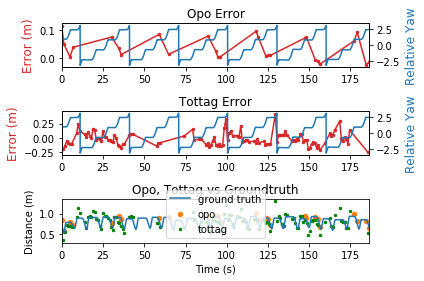

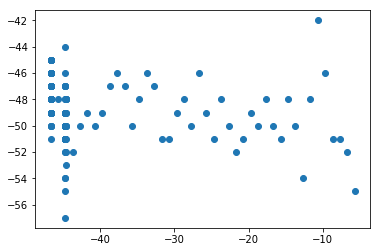

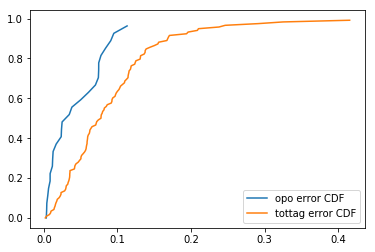

./exp/cse_building/level3_sideline2_rtt_run1/rtt_1640928753.log ./exp/cse_building/level3_sideline2_rtt_run1/rtt2_1640928753.log
<FileCapture ./exp/cse_building/level3_sideline2_rtt_run1/capture.pcapng>
len raw1 186 len raw2 177 combined: 363
clumped raw 212
len rssi1 288 len rssi2 264 combined: 552
clumped 282
min, max, interval for timestamps: 1640928771.760726 1640928882.498105 110.73737907409668
opo data points: 8


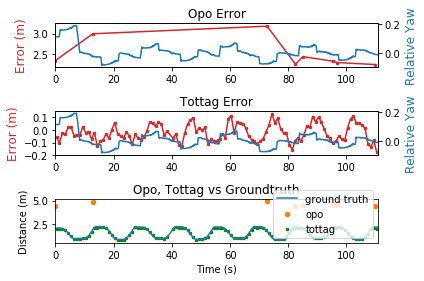

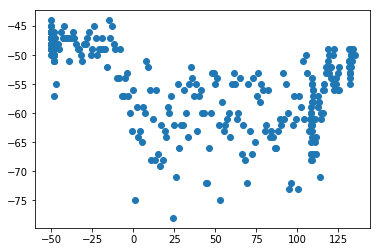

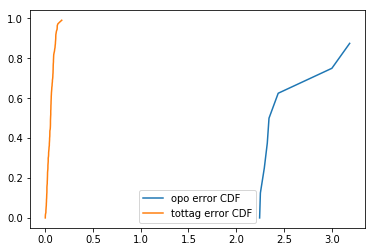

./exp/cse_building/level3_sideline2_rtt_run2_wrong/rtt_1640931065.log ./exp/cse_building/level3_sideline2_rtt_run2_wrong/rtt2_1640931065.log
<FileCapture ./exp/cse_building/level3_sideline2_rtt_run2_wrong/capture.pcapng>
len raw1 178 len raw2 143 combined: 321
clumped raw 192
len rssi1 386 len rssi2 382 combined: 768
clumped 390
min, max, interval for timestamps: 1640931082.633237 1640931192.699362 110.06612515449524
opo data points: 17


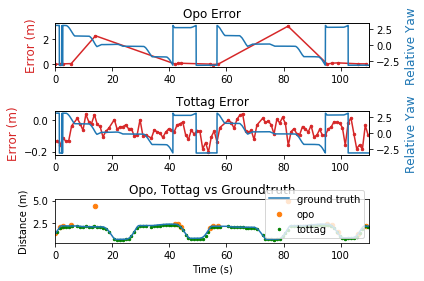

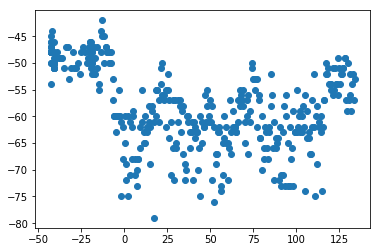

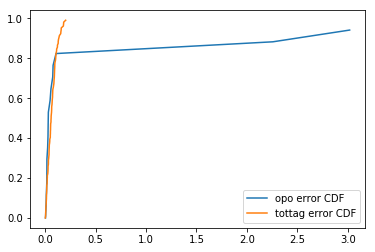

./exp/cse_building/level3_sideline2_rtt_run2/rtt_1640931856.log ./exp/cse_building/level3_sideline2_rtt_run2/rtt2_1640931856.log
<FileCapture ./exp/cse_building/level3_sideline2_rtt_run2/capture.pcapng>
len raw1 185 len raw2 159 combined: 344
clumped raw 202
len rssi1 302 len rssi2 280 combined: 582
clumped 297
min, max, interval for timestamps: 1640931877.305894 1640931988.327828 111.02193403244019
opo data points: 44


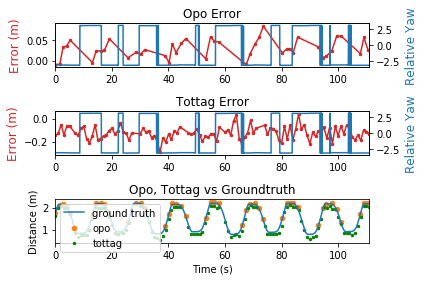

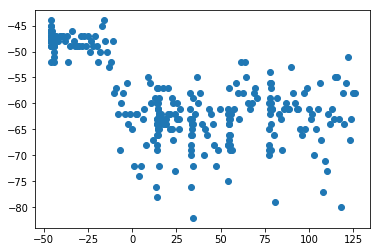

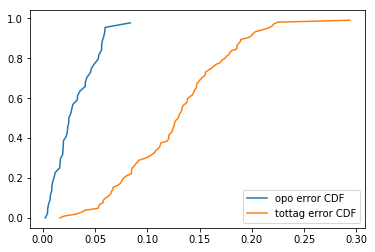

./exp/cse_building/level3_sideline2_rtt_run3/rtt_1640933775.log ./exp/cse_building/level3_sideline2_rtt_run3/rtt2_1640933775.log
<FileCapture ./exp/cse_building/level3_sideline2_rtt_run3/capture.pcapng>
len raw1 258 len raw2 203 combined: 461
clumped raw 259
len rssi1 444 len rssi2 402 combined: 846
clumped 427
min, max, interval for timestamps: 1640933793.745188 1640933905.587306 111.84211802482605
opo data points: 51


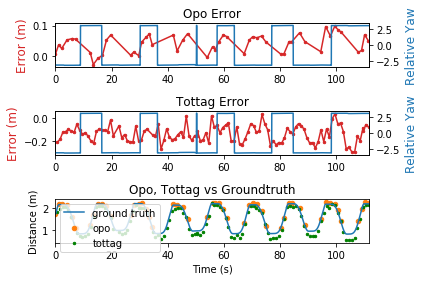

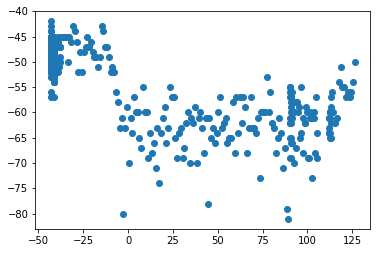

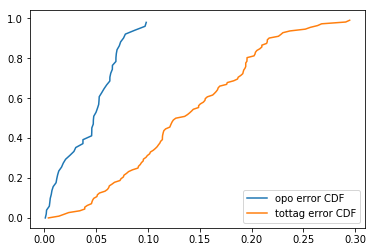

./exp/cse_building/level3_sideline2_rtt_run4/rtt_1640935544.log ./exp/cse_building/level3_sideline2_rtt_run4/rtt2_1640935544.log
<FileCapture ./exp/cse_building/level3_sideline2_rtt_run4/capture.pcapng>
len raw1 260 len raw2 244 combined: 504
clumped raw 282
len rssi1 423 len rssi2 424 combined: 847
clumped 429
min, max, interval for timestamps: 1640935562.791694 1640935674.54885 111.75715613365173
opo data points: 51


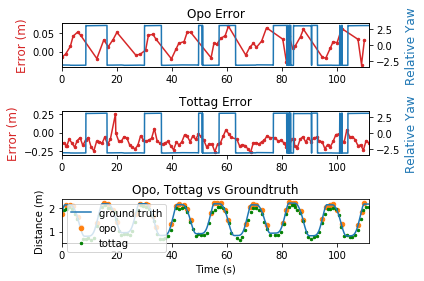

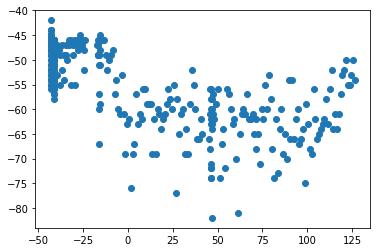

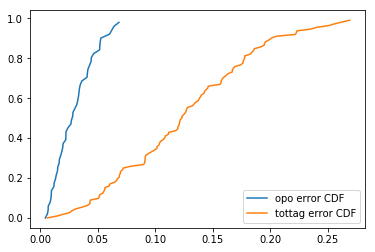

In [2]:
path='./exp/cse_building/level3_circle1_rtt_run1/'
process_rtt(path, 'circle_clock1', [0,-0.3775], ul_count_cutoff=65)

path='./exp/cse_building/level3_sideline2_rtt_run1/'
process_rtt(path, 'sideline2', [0,-0.3625], ul_count_cutoff=65)
  
path='./exp/cse_building/level3_sideline2_rtt_run2_wrong/' # not a line...
process_rtt(path, 'sideline2', [0,-0.3780], ul_count_cutoff=65)

path='./exp/cse_building/level3_sideline2_rtt_run2/'
process_rtt(path, 'sideline2', [0,-0.3700], ul_count_cutoff=65)  

path='./exp/cse_building/level3_sideline2_rtt_run3/'
process_rtt(path, 'sideline2', [0,-0.3725], ul_count_cutoff=65)    

path='./exp/cse_building/level3_sideline2_rtt_run4/'
process_rtt(path, 'sideline2', [0,-0.3780], ul_count_cutoff=65)  

./exp/cse_building/level1_circle1_rtt_run1/rtt_1640983417.log ./exp/cse_building/level1_circle1_rtt_run1/rtt2_1640983417.log
<FileCapture ./exp/cse_building/level1_circle1_rtt_run1/capture.pcapng>
len raw1 161 len raw2 137 combined: 298
clumped raw 175
len rssi1 232 len rssi2 230 combined: 462
clumped 232
min, max, interval for timestamps: 1640983417.39234 1640983539.118815 121.72647500038147
opo data points: 20


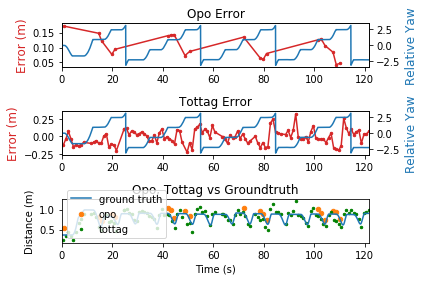

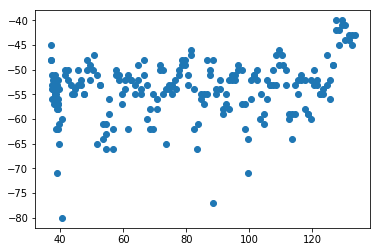

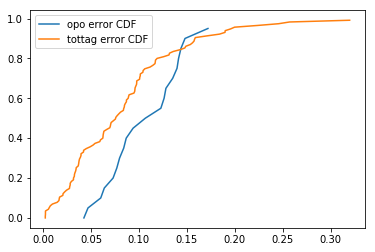

./exp/cse_building/level1_circle1_rtt_run2/rtt_1640984117.log ./exp/cse_building/level1_circle1_rtt_run2/rtt2_1640984117.log
<FileCapture ./exp/cse_building/level1_circle1_rtt_run2/capture.pcapng>
len raw1 164 len raw2 533 combined: 697
clumped raw 383
len rssi1 238 len rssi2 946 combined: 1184
clumped 598
min, max, interval for timestamps: 1640984130.753506 1640984239.850257 109.09675097465515
opo data points: 17


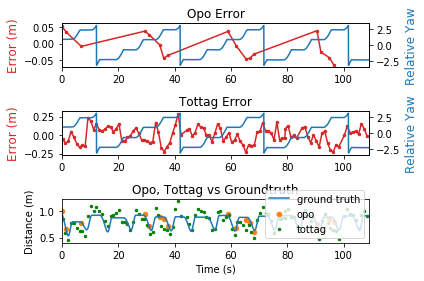

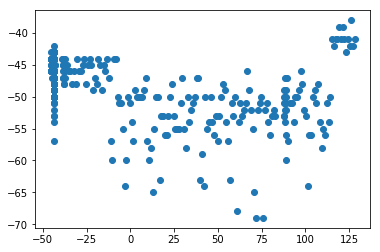

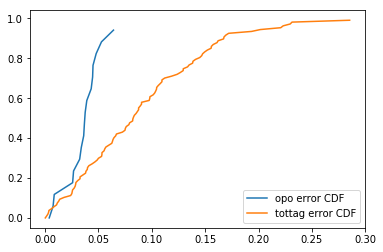

./exp/cse_building/level1_circle1_rtt_run3/rtt_1640984666.log ./exp/cse_building/level1_circle1_rtt_run3/rtt2_1640984666.log
<FileCapture ./exp/cse_building/level1_circle1_rtt_run3/capture.pcapng>
len raw1 164 len raw2 163 combined: 327
clumped raw 191
len rssi1 246 len rssi2 250 combined: 496
clumped 253
min, max, interval for timestamps: 1640984666.361123 1640984789.128031 122.76690793037415
opo data points: 18


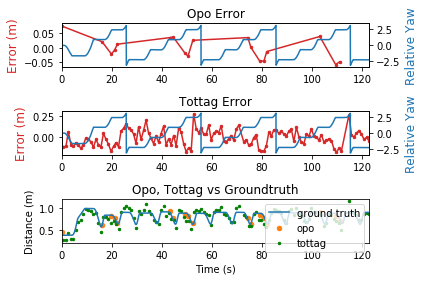

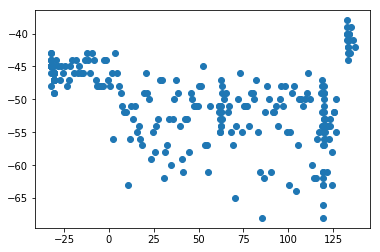

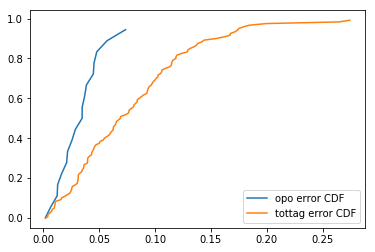

In [3]:
path='./exp/cse_building/level1_circle1_rtt_run1/'    
process_rtt(path, 'circle_clock1', [0,-0.3680], ul_count_cutoff=65)   

path='./exp/cse_building/level1_circle1_rtt_run2/'
process_rtt(path, 'circle_clock1', [0,-0.3635], ul_count_cutoff=65) 

path='./exp/cse_building/level1_circle1_rtt_run3/'
process_rtt(path, 'circle_clock1', [0,-0.3730], ul_count_cutoff=65)

./exp/cse_building/level1_sideline2_rtt_run1/rtt_1640985109.log ./exp/cse_building/level1_sideline2_rtt_run1/rtt2_1640985109.log
<FileCapture ./exp/cse_building/level1_sideline2_rtt_run1/capture.pcapng>
len raw1 167 len raw2 170 combined: 337
clumped raw 191
len rssi1 246 len rssi2 277 combined: 523
clumped 270
min, max, interval for timestamps: 1640985109.350747 1640985239.621445 130.27069783210754
opo data points: 54


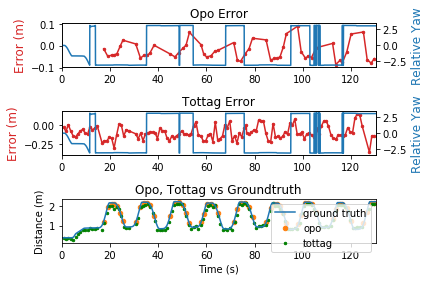

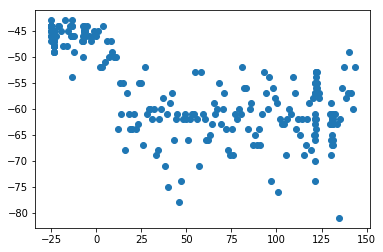

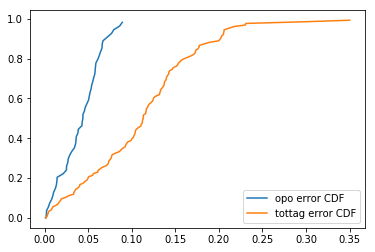

./exp/cse_building/level1_sideline2_rtt_run2/rtt_1640985998.log ./exp/cse_building/level1_sideline2_rtt_run2/rtt2_1640985998.log
<FileCapture ./exp/cse_building/level1_sideline2_rtt_run2/capture.pcapng>
len raw1 170 len raw2 654 combined: 824
clumped raw 443
len rssi1 263 len rssi2 966 combined: 1229
clumped 620
min, max, interval for timestamps: 1640985998.40662 1640986127.64182 129.2351999282837
opo data points: 54


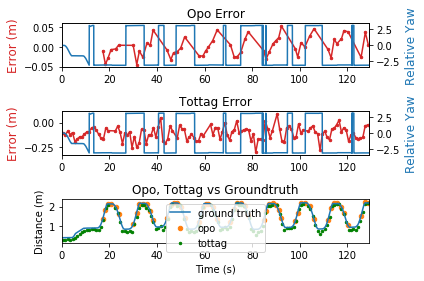

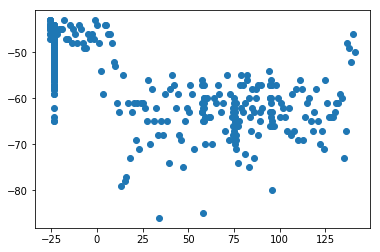

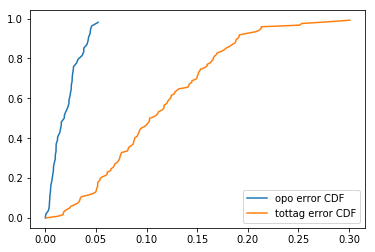

./exp/cse_building/level1_sideline2_rtt_run3/rtt_1640986502.log ./exp/cse_building/level1_sideline2_rtt_run3/rtt2_1640986502.log
<FileCapture ./exp/cse_building/level1_sideline2_rtt_run3/capture.pcapng>
len raw1 161 len raw2 276 combined: 437
clumped raw 249
len rssi1 225 len rssi2 564 combined: 789
clumped 399
min, max, interval for timestamps: 1640986518.881486 1640986631.585059 112.70357298851013
opo data points: 52


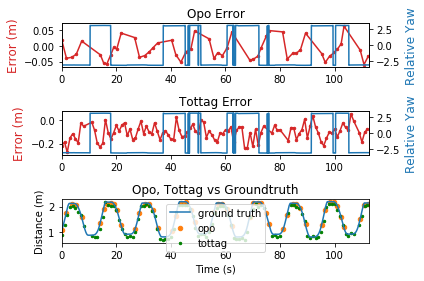

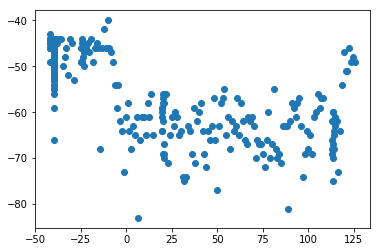

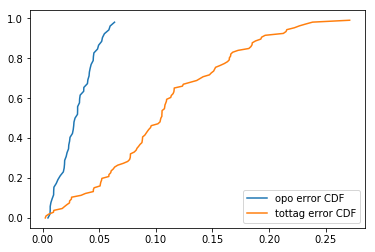

./exp/cse_building/level1_sideline2_rtt_run4/rtt_1640986976.log ./exp/cse_building/level1_sideline2_rtt_run4/rtt2_1640986976.log
<FileCapture ./exp/cse_building/level1_sideline2_rtt_run4/capture.pcapng>
len raw1 391 len raw2 368 combined: 759
clumped raw 409
len rssi1 638 len rssi2 647 combined: 1285
clumped 648
min, max, interval for timestamps: 1640986976.333794 1640987105.547221 129.2134268283844
opo data points: 51


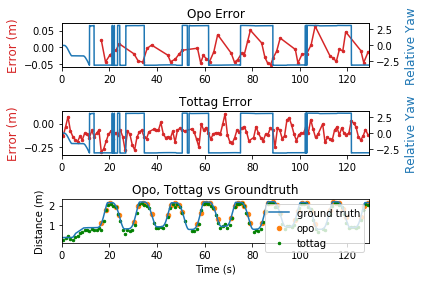

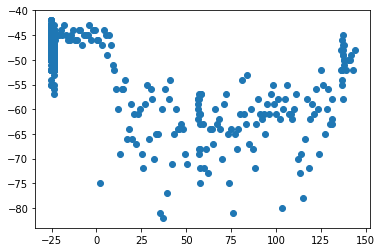

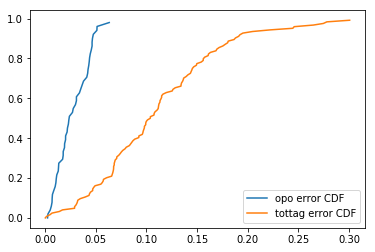

In [4]:
path='./exp/cse_building/level1_sideline2_rtt_run1/'
process_rtt(path, 'sideline2', [0,-0.3785], ul_count_cutoff=65)

path='./exp/cse_building/level1_sideline2_rtt_run2/'
process_rtt(path, 'sideline2', [0,-0.3805], ul_count_cutoff=65)

path='./exp/cse_building/level1_sideline2_rtt_run3/'
process_rtt(path, 'sideline2', [0,-0.3780], ul_count_cutoff=65)

path='./exp/cse_building/level1_sideline2_rtt_run4/'
process_rtt(path, 'sideline2', [0,-0.3755], ul_count_cutoff=65)

./exp/placeA/level1_sideline2_rtt_run1/rtt_1641076838.log ./exp/placeA/level1_sideline2_rtt_run1/rtt2_1641076838.log
<FileCapture ./exp/placeA/level1_sideline2_rtt_run1/capture.pcapng>
len raw1 154 len raw2 392 combined: 546
clumped raw 293
len rssi1 218 len rssi2 554 combined: 772
clumped 393
min, max, interval for timestamps: 1641076855.8348 1641076968.383131 112.54833102226257
opo data points: 56


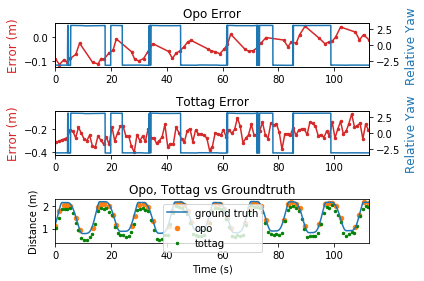

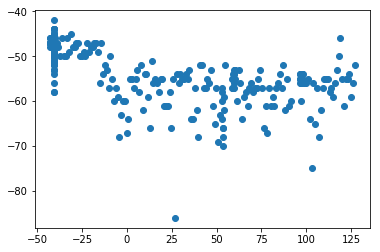

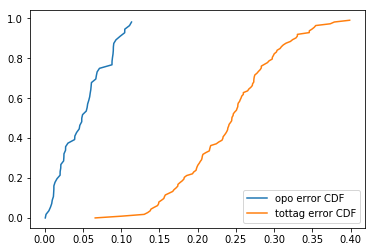

./exp/placeA/level1_sideline2_rtt_run2/rtt_1641077553.log ./exp/placeA/level1_sideline2_rtt_run2/rtt2_1641077553.log
<FileCapture ./exp/placeA/level1_sideline2_rtt_run2/capture.pcapng>
len raw1 83 len raw2 194 combined: 277
clumped raw 207
len rssi1 308 len rssi2 476 combined: 784
clumped 401
min, max, interval for timestamps: 1641077570.635044 1641077682.896167 112.26112294197083
opo data points: 53


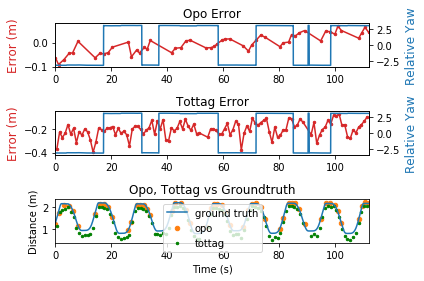

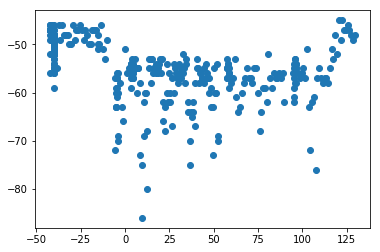

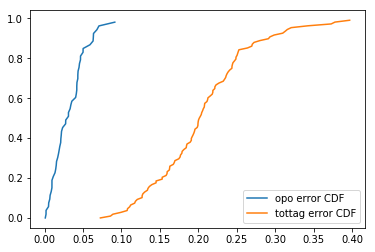

./exp/placeA/level1_sideline2_rtt_run3/rtt_1641077942.log ./exp/placeA/level1_sideline2_rtt_run3/rtt2_1641077942.log
<FileCapture ./exp/placeA/level1_sideline2_rtt_run3/capture.pcapng>
len raw1 96 len raw2 382 combined: 478
clumped raw 286
len rssi1 133 len rssi2 341 combined: 474
clumped 245
min, max, interval for timestamps: 1641077958.946088 1641078071.815193 112.86910486221313
opo data points: 52


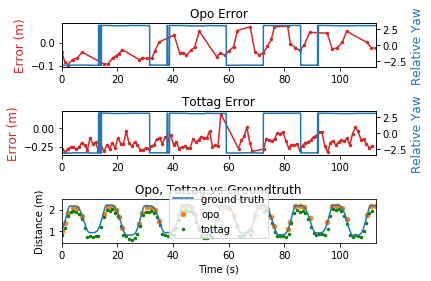

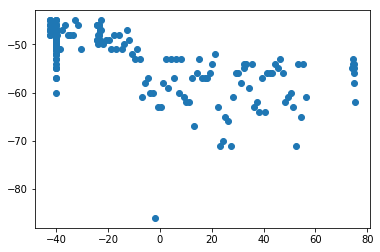

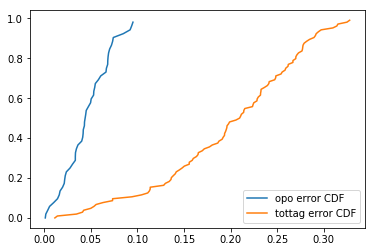

./exp/placeA/level1_sideline2_rtt_run4/rtt_1641078437.log ./exp/placeA/level1_sideline2_rtt_run4/rtt2_1641078437.log
<FileCapture ./exp/placeA/level1_sideline2_rtt_run4/capture.pcapng>
len raw1 171 len raw2 265 combined: 436
clumped raw 236
len rssi1 212 len rssi2 207 combined: 419
clumped 211
min, max, interval for timestamps: 1641078454.591455 1641078567.84578 113.2543249130249
opo data points: 56


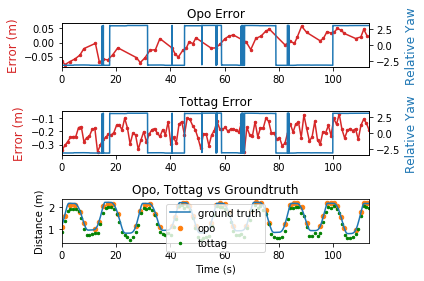

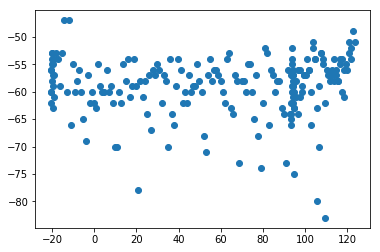

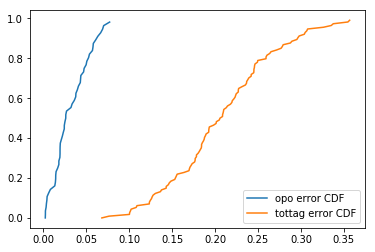

./exp/placeA/level1_sideline2_rtt_run5/rtt_1641078808.log ./exp/placeA/level1_sideline2_rtt_run5/rtt2_1641078808.log
<FileCapture ./exp/placeA/level1_sideline2_rtt_run5/capture.pcapng>
len raw1 132 len raw2 347 combined: 479
clumped raw 261
len rssi1 228 len rssi2 536 combined: 764
clumped 388
min, max, interval for timestamps: 1641078825.723988 1641078938.310295 112.58630704879761
opo data points: 54


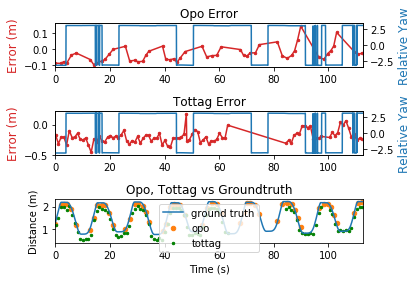

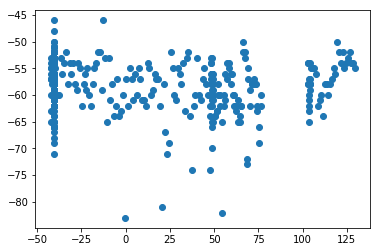

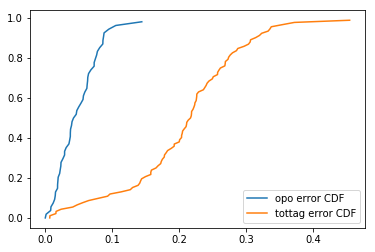

In [5]:
path='./exp/placeA/level1_sideline2_rtt_run1/'
process_rtt(path, 'sideline2', [0,-0.3732], ul_count_cutoff=65)
#0.3732

path='./exp/placeA/level1_sideline2_rtt_run2/'
process_rtt(path, 'sideline2', [0,-0.3715], ul_count_cutoff=65)


path='./exp/placeA/level1_sideline2_rtt_run3/' #missing late rssi
process_rtt(path, 'sideline2', [0,-0.3760], ul_count_cutoff=65)
#0.3760

path='./exp/placeA/level1_sideline2_rtt_run4/' #missing late rssi
process_rtt(path, 'sideline2', [0,-0.3707], ul_count_cutoff=65)
#0.3707

path='./exp/placeA/level1_sideline2_rtt_run5/' #missing late rssi
process_rtt(path, 'sideline2', [0,-0.3707], ul_count_cutoff=65)

./exp/placeA/level1_circle1_rtt_run1/rtt_1641079257.log ./exp/placeA/level1_circle1_rtt_run1/rtt2_1641079257.log
<FileCapture ./exp/placeA/level1_circle1_rtt_run1/capture.pcapng>
len raw1 121 len raw2 390 combined: 511
clumped raw 275
len rssi1 172 len rssi2 493 combined: 665
clumped 349
min, max, interval for timestamps: 1641079270.351326 1641079381.064541 110.71321511268616
opo data points: 19


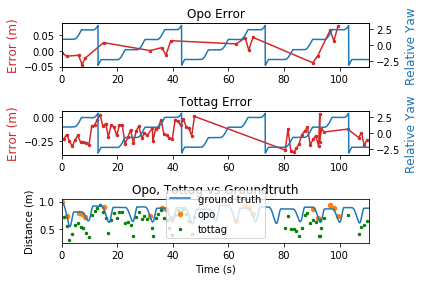

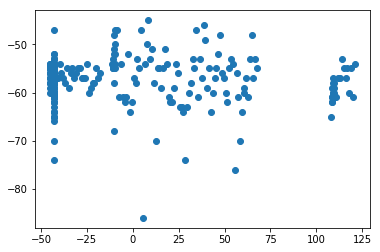

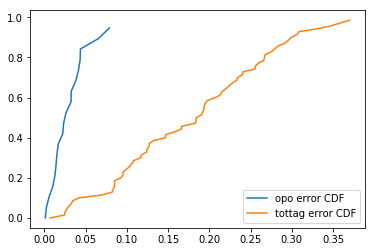

./exp/placeA/level1_circle1_rtt_run2/rtt_1641079676.log ./exp/placeA/level1_circle1_rtt_run2/rtt2_1641079676.log
<FileCapture ./exp/placeA/level1_circle1_rtt_run2/capture.pcapng>
len raw1 159 len raw2 409 combined: 568
clumped raw 304
len rssi1 242 len rssi2 540 combined: 782
clumped 395
min, max, interval for timestamps: 1641079690.516759 1641079800.410111 109.89335203170776
opo data points: 20


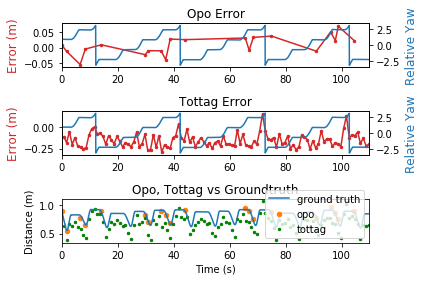

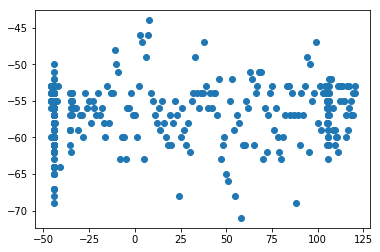

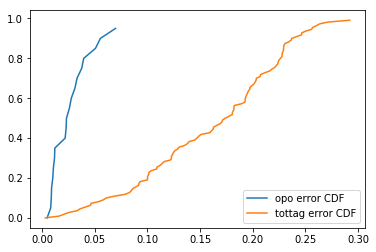

./exp/placeA/level1_circle1_rtt_run3/rtt_1641080085.log ./exp/placeA/level1_circle1_rtt_run3/rtt2_1641080085.log
<FileCapture ./exp/placeA/level1_circle1_rtt_run3/capture.pcapng>
len raw1 150 len raw2 390 combined: 540
clumped raw 293
len rssi1 264 len rssi2 577 combined: 841
clumped 435
min, max, interval for timestamps: 1641080100.685115 1641080210.059982 109.37486696243286
opo data points: 21


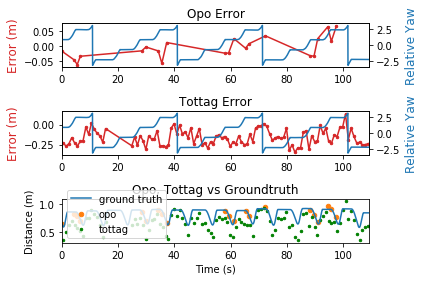

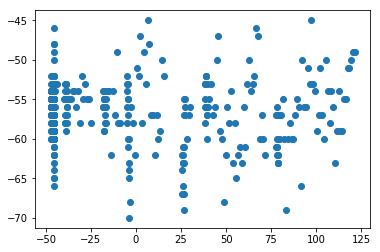

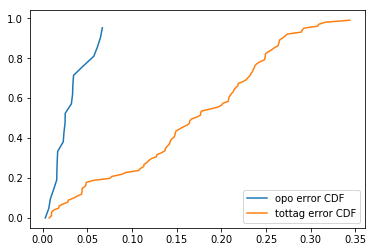

In [7]:
path='./exp/placeA/level1_circle1_rtt_run1/'    
process_rtt(path, 'circle_clock1', [0,-0.3755], ul_count_cutoff=65)  
#0.3755

path='./exp/placeA/level1_circle1_rtt_run2/'    
process_rtt(path, 'circle_clock1', [0,-0.3630], ul_count_cutoff=65) 

path='./exp/placeA/level1_circle1_rtt_run3/'    
process_rtt(path, 'circle_clock1', [0,-0.3770], ul_count_cutoff=65) 

./exp/placeA/level3_sideline2_rtt_run1/rtt_1641159053.log ./exp/placeA/level3_sideline2_rtt_run1/rtt2_1641159053.log
<FileCapture ./exp/placeA/level3_sideline2_rtt_run1/capture.pcapng>
len raw1 170 len raw2 58 combined: 228
clumped raw 182
len rssi1 209 len rssi2 496 combined: 705
clumped 354
min, max, interval for timestamps: 1641159072.349933 1641159183.376226 111.0262930393219
opo data points: 26


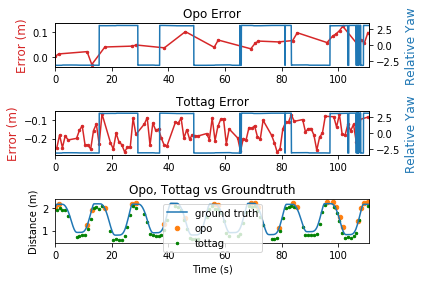

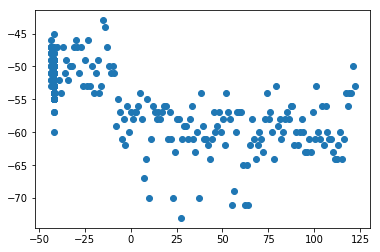

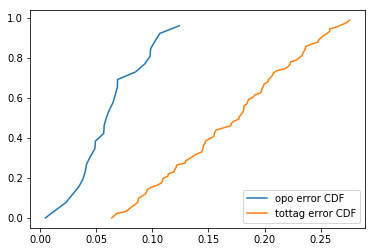

./exp/placeA/level3_sideline2_rtt_run2/rtt_1641159598.log ./exp/placeA/level3_sideline2_rtt_run2/rtt2_1641159598.log
<FileCapture ./exp/placeA/level3_sideline2_rtt_run2/capture.pcapng>
len raw1 188 len raw2 186 combined: 374
clumped raw 206
len rssi1 305 len rssi2 215 combined: 520
clumped 265
min, max, interval for timestamps: 1641159616.842705 1641159728.468209 111.62550401687622
opo data points: 43


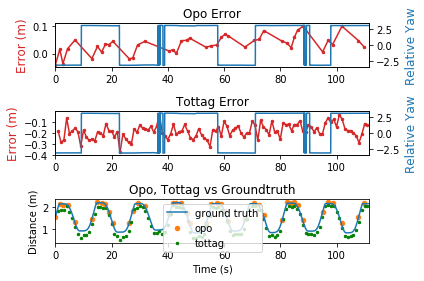

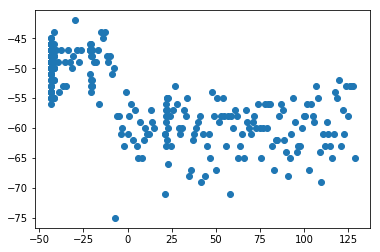

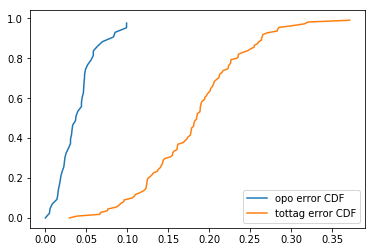

./exp/placeA/level3_sideline2_rtt_run3/rtt_1641160022.log ./exp/placeA/level3_sideline2_rtt_run3/rtt2_1641160022.log
<FileCapture ./exp/placeA/level3_sideline2_rtt_run3/capture.pcapng>
len raw1 329 len raw2 174 combined: 503
clumped raw 272
len rssi1 557 len rssi2 196 combined: 753
clumped 384
min, max, interval for timestamps: 1641160043.954277 1641160143.174005 99.21972799301147
opo data points: 30


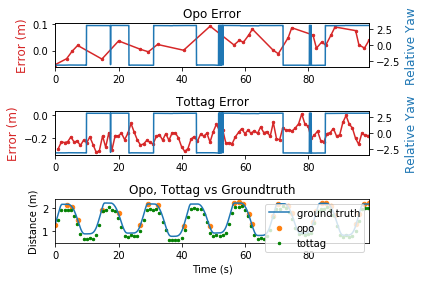

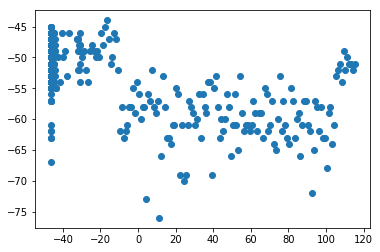

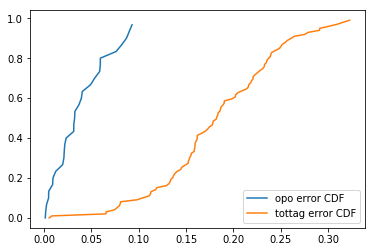

./exp/placeA/level3_sideline2_rtt_run4/rtt_1641160384.log ./exp/placeA/level3_sideline2_rtt_run4/rtt2_1641160384.log
<FileCapture ./exp/placeA/level3_sideline2_rtt_run4/capture.pcapng>
len raw1 293 len raw2 199 combined: 492
clumped raw 268
len rssi1 435 len rssi2 230 combined: 665
clumped 340
min, max, interval for timestamps: 1641160409.640317 1641160513.968769 104.32845211029053
opo data points: 23


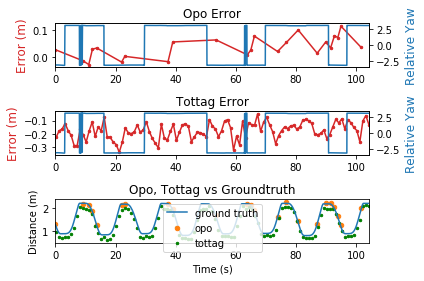

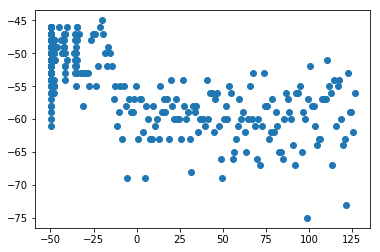

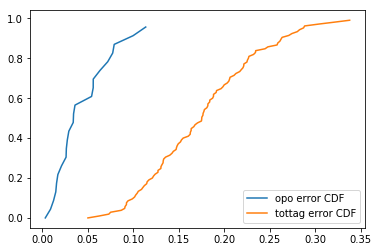

In [8]:
path='./exp/placeA/level3_sideline2_rtt_run1/'
process_rtt(path, 'sideline2', [0,-0.3590], ul_count_cutoff=65)

path='./exp/placeA/level3_sideline2_rtt_run2/'
process_rtt(path, 'sideline2', [0,-0.3795], ul_count_cutoff=65)

path='./exp/placeA/level3_sideline2_rtt_run3/'
process_rtt(path, 'sideline2', [0,-0.3735], ul_count_cutoff=65)
#0.3735

path='./exp/placeA/level3_sideline2_rtt_run4/'
process_rtt(path, 'sideline2', [0,-0.3750], ul_count_cutoff=65)
#0.3750

./exp/placeA/level3_circle1_rtt_run1/rtt_1641160984.log ./exp/placeA/level3_circle1_rtt_run1/rtt2_1641160984.log
<FileCapture ./exp/placeA/level3_circle1_rtt_run1/capture.pcapng>
len raw1 426 len raw2 574 combined: 1000
clumped raw 539
len rssi1 1095 len rssi2 1097 combined: 2192
clumped 1101
min, max, interval for timestamps: 1641161005.806704 1641161097.980118 92.1734139919281
opo data points: 15


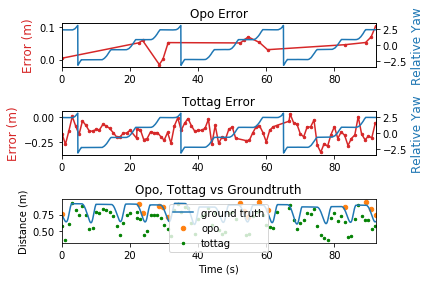

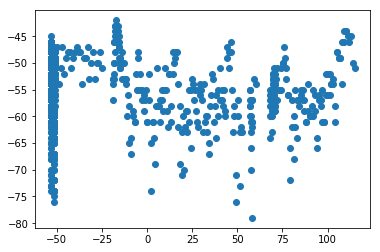

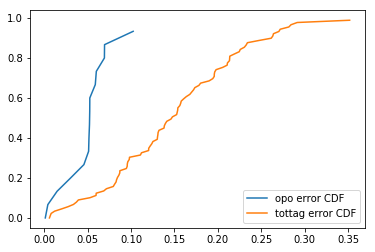

./exp/placeA/level3_circle1_rtt_run2/rtt_1641161305.log ./exp/placeA/level3_circle1_rtt_run2/rtt2_1641161305.log
<FileCapture ./exp/placeA/level3_circle1_rtt_run2/capture.pcapng>
len raw1 250 len raw2 305 combined: 555
clumped raw 294
len rssi1 417 len rssi2 412 combined: 829
clumped 425
min, max, interval for timestamps: 1641161321.719273 1641161415.868312 94.1490387916565
opo data points: 11


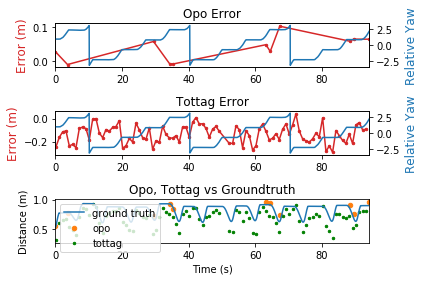

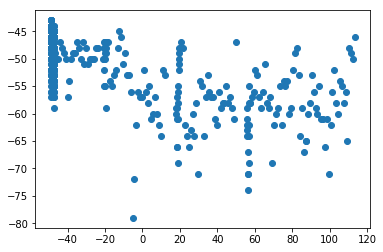

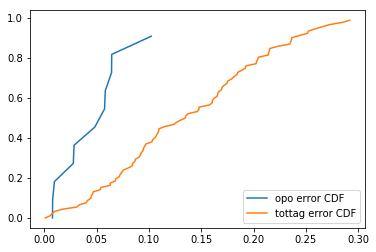

./exp/placeA/level3_circle1_rtt_run3/rtt_1641162124.log ./exp/placeA/level3_circle1_rtt_run3/rtt2_1641162124.log
<FileCapture ./exp/placeA/level3_circle1_rtt_run3/capture.pcapng>
len raw1 351 len raw2 22 combined: 373
clumped raw 240
len rssi1 228 len rssi2 22 combined: 250
clumped 162
min, max, interval for timestamps: 1641162140.319805 1641162237.082839 96.7630341053009
opo data points: 17


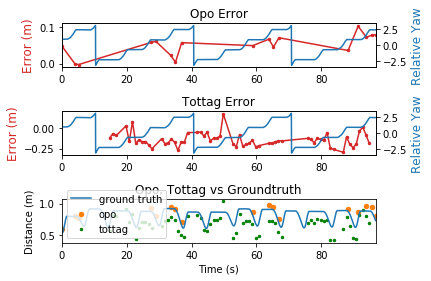

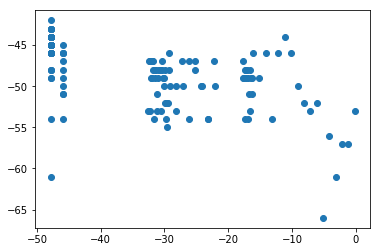

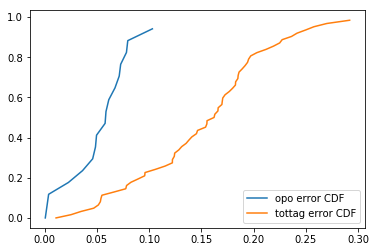

./exp/placeA/level3_circle1_rtt_run4/rtt_1641162581.log ./exp/placeA/level3_circle1_rtt_run4/rtt2_1641162581.log
<FileCapture ./exp/placeA/level3_circle1_rtt_run4/capture.pcapng>
len raw1 337 len raw2 174 combined: 511
clumped raw 264
len rssi1 254 len rssi2 233 combined: 487
clumped 246
min, max, interval for timestamps: 1641162596.831601 1641162694.779303 97.94770216941833
opo data points: 17


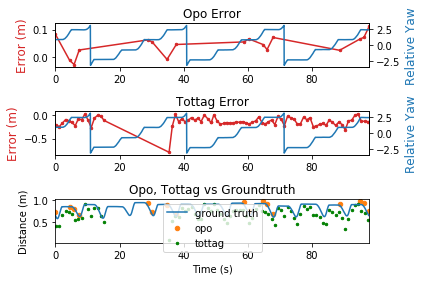

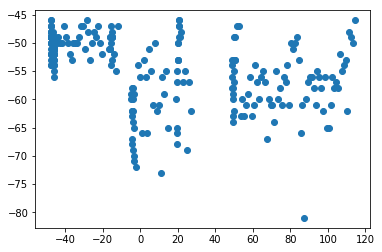

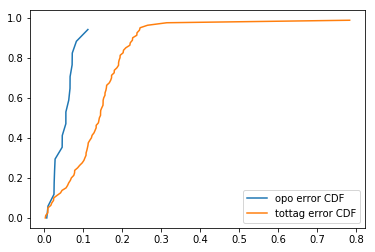

./exp/placeA/level3_circle1_rtt_run6/rtt_1641163086.log ./exp/placeA/level3_circle1_rtt_run6/rtt2_1641163086.log
<FileCapture ./exp/placeA/level3_circle1_rtt_run6/capture.pcapng>
len raw1 263 len raw2 0 combined: 263
clumped raw 198
len rssi1 414 len rssi2 0 combined: 414
clumped 307
min, max, interval for timestamps: 1641163102.284568 1641163200.091363 97.80679488182068
opo data points: 19


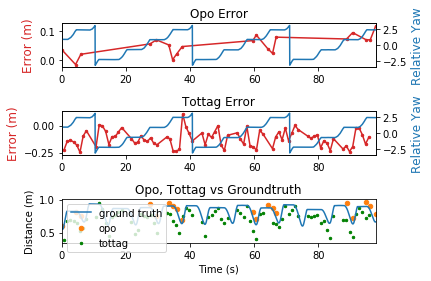

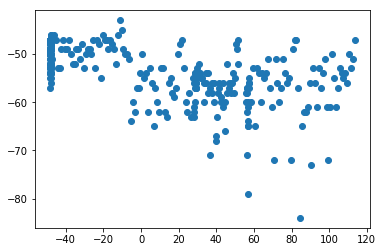

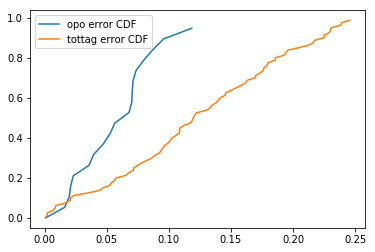

In [9]:
path='./exp/placeA/level3_circle1_rtt_run1/'    
process_rtt(path, 'circle_clock1', [0,-0.3725], ul_count_cutoff=65) 

path='./exp/placeA/level3_circle1_rtt_run2/'    
process_rtt(path, 'circle_clock1', [0,-0.3690], ul_count_cutoff=65) 
#0.3690

path='./exp/placeA/level3_circle1_rtt_run3/'     ##missing much rssi
process_rtt(path, 'circle_clock1', [0,-0.3690], ul_count_cutoff=65) 

path='./exp/placeA/level3_circle1_rtt_run4/'     ##missing some tottag data
process_rtt(path, 'circle_clock1', [0,-0.3780], ul_count_cutoff=65) 

path='./exp/placeA/level3_circle1_rtt_run6/'     ##missing some tottag data
process_rtt(path, 'circle_clock1', [0,-0.3615], ul_count_cutoff=65) 